<div align="center">
    <h1><strong>Software de diseño automático</strong></h1>
</div>

---

<h2 style="text-align:center"><strong>Resumen</strong></h2>
<div style="text-align:justify">
    <br>
    Se desarrolló una metodología de diseño automático del sistema de elución y filtrado que simula el comportamiento fluidodinámico durante la etapa de filtrado, permitiendo predecir el grado de concentración de partículas a lo largo del sistema a través de un modelo numérico basado en CFD-DEM. Esta metodología ha sido elaborada con herramientas de código abierto. Utilizando <i>Python</i> como lenguaje base, <i>Jupyter</i> como entorno de desarrollo, <i>ParaView</i> como plataforma de análisis de resultados y librerías de <i>C++</i> (como Yade, LIGGGHTS y OpenFOAM) para el desarrollo de las simulaciones numéricas.
</div>

<br>

___Palabras clave:___ CFD-DEM, OpenFOAM, Python, Jupyter, ParaView.

---

# __5. Diseño del sistema__

El diseño del sedimentador de placas paralelas se resume en lo siguiente:

1. Definición de propiedades del _fluido_ y _material particulado_.
2. Cálculo de las propiedades termodinámicas del fluido.
3. Definición de la geometría del panel de lamelas.
4. Cálculo de propiedades de flujo.
5. Resultados.

## 5.1. Generalidades

Define las propiedades del _fluido_ y _material particulado_:

In [2]:
from App.Generalidades.Data import *
data = Datos()
data

Con base en los datos suministrados, las propiedades termodinámicas del solvente se pueden apreciar a continuación.

In [6]:
from App.Generalidades.Read import Read
from App.Generalidades.Propiedades import *
general = Read(data)
prop = SolProp(general)()
prop = prop['mezcla']

#### _Propiedades termodinámicas de la mezcla agua - etanol al $50[\%] $_
        

| Propiedad | Valor |
|---|---|
| Densidad $[kg / m^3 ]$ | $889.4$ |
|Visc. cinemática $kg \, m/s$|$1.06 \, 10 ^{-6} $|
|Visc. dinámica $m^2/s$|$9.23 \, 10 ^{-4} $|
| Relación de densidades | $1.91$ |
        

## 5.2. Velocidad de sedimentación

Conociendo las propiedades del solvente y del material particulado, se puede calcular la _velocidad de sedimentación_ de las partículas a parti de la Ecuación \ref{Vsed}.

$$
\begin{equation}
    U_{max} = \sqrt{\frac{2 V \left(\rho _s - \rho _f \right) g}{C \, A_n \, \rho _f}}   
    \label{Vsed}
    \tag{1}
\end{equation}
$$

El coeficiente de arrastre $C$ se calcula de la siguiente forma:

$$
    \begin{equation}
        C = \frac{24}{Re_s} + \frac{3}{Re _s ^{1/2}} + 0.34
        \tag{2}
    \end{equation}
$$

El número de Reynolds del fluido colindante con la partícula sólida se calucla como se muestra en la Ecuación \ref{Res}.

$$
    \begin{equation}
        Re _s = \frac{d_p \, U}{\mu}
        \label{Res}
        \tag{3}
    \end{equation}
$$

Para resolver la Ecuación \ref{Vsed}, es necesario emplear un proceso iterativo de cálculo.

In [7]:
from App.Sedimentation.Calculos import *
dataV = VelSed(general['Solid'], prop)()

El proceso iterativo, con una estimación de error del $0.01 \%$, arroja los siguientes resultados: $U = 0.022 [m/s]$ y un número de Reynolds de $Re_s = 5.115$. 

## 5.3. Dimensionamiento

A continuación, se define la geometría del panel de lamelas para el diseño del sistema de sedimentación. 

In [8]:
from App.Generalidades.Lamelas import *
geo = Geometry()
geo 

In [9]:
#%matplotlib
datos_geo = Read(geo, datos={'lamela':{}})
datos_geo = datos_geo['lamela']
lamela = Lamela(general['Fluido'], prop, datos_geo, dataV)()

| Propiedad | Valor |
|---|---|
| $Q \, [L / min ]$ | 3.333 |
| $W \, [m]$|0.022|
|$v_0 \, [cm / s]$|1.014|
| $Re$ | 478.993 |
        

## 5.4. Velocidad crítica de sedimentación

La velocidad crítica de sedimentación de las partículas se calcula a partir de la Ecuación \ref{yao}.

$$
\begin{equation}
    U_{c} = \frac{v_0}{\sin \theta + \frac{L}{b} \cos \theta}
    \label{yao}
    \tag{6}
\end{equation}
$$

De la Ecuación \ref{yao}, $v_0$ es la magnitud del flujo, $\frac{L}{b}$ es la relación entre la longitud de una lamela y el ancho de la misma; y $\theta$ es el ángulo de inclinación de las placas.

In [10]:
VelCr(lamela, datos_geo)

La velocidad crítica de asentamiento tiene un valor de $0.208 [cm/s]$.

# __6. Modelo CFD-DEM__

El procedimiento para el planteamiento del modelo CFD-DEM consiste en lo siguiente:
1. Definición de la geometría del sistema.
2. Mallado de la geometría.
3. Definición de condiciones de frontera
4. Desarrollo de la simulación.
5. Postprocesamiento y presentación de resultados.
6. Análisis de resultados.



## 6.1. Discretización del dominio
El mallado consiste en al discretizaciòn del dominio geométrico del problema.

<div align="center">
    <img src="Images/Elemento.png" style="width: 300px;" />
</div>
<div align="center">
    <i>Figura 2.</i> Discretización del dominio.
</div>

El mallado de la geometría se especifica a continuación.

In [11]:
from App.CFD_DEM.Geom import *
from App.Generalidades.Read import *
from ipywidgets import Button, Layout, HBox
size = Malla(round((2*lamela['QT'])/(125*pi*prop['visc']),2), datos_geo)
a = HBox([size], layout=Layout(height='200px', overflow_y='auto'))
display(a)

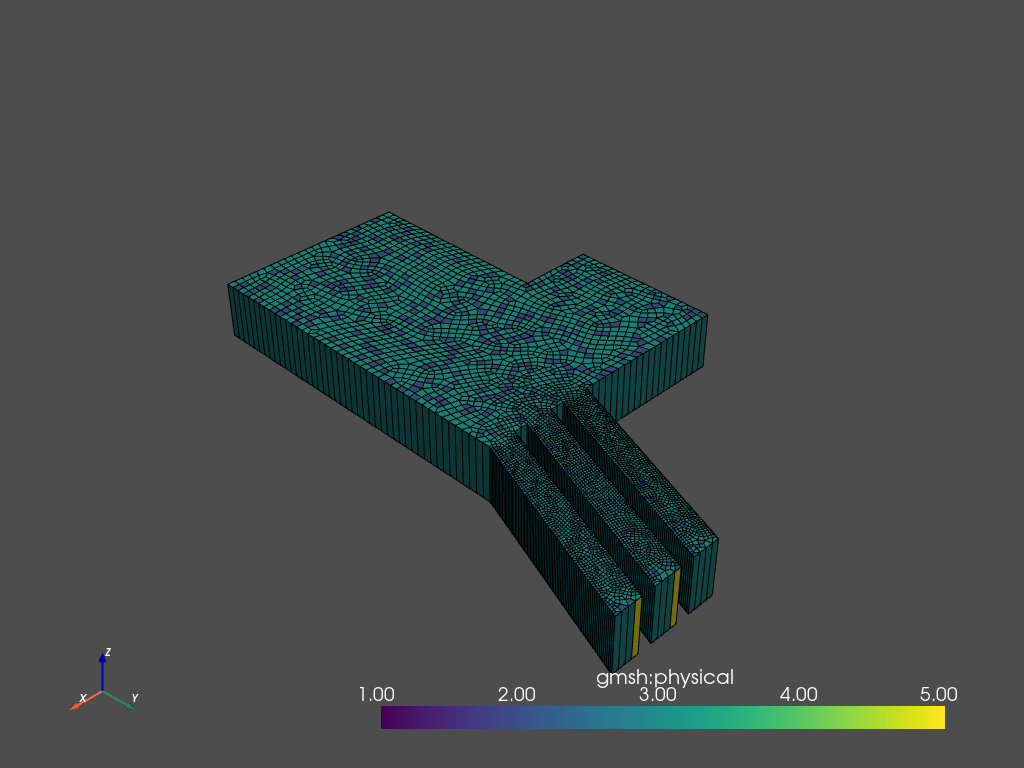

In [23]:
import warnings
datos_geo = ReadMesh(size)
datos_geo['DI [m]'] = round((2*lamela['QT'])/(125*pi*prop['visc']),2)
warnings.filterwarnings('ignore')
DEM = True      #Cambiar modelo de malla en el directorio CFD-DEM
Dibujar(datos_geo, lamela, size.children[0].children[0].value, size.children[0].children[1].value, general['Solid']['Tamaño de partícula medio [um]'], (size.children[2].children[0].value, size.children[2].children[1].value), DEM)

La malla desarrollada presenta las siguientes características:

In [17]:
import pyvista as pv
res_malla = pv.read("out.vtk")
res_malla

UnstructuredGrid (0x7f0c9fb75ca0)
  N Cells:	12992
  N Points:	9262
  X Bounds:	0.000e+00, 6.109e-01
  Y Bounds:	-6.160e-01, 3.460e-01
  Z Bounds:	0.000e+00, 1.000e-03
  N Arrays:	2

Resultados de la evaluación de malla a través del comando `checkMesh`, de OpenFoam:

In [18]:
from App.CFD_DEM.Malla import *
ToFoam()

|__Parámetro__|__Valor__|
|--------|-------------|
|Apertura _máxima_ entre elementos| 16.4295|
|Checkeo de _no_ ortogonalidad|OK. |
|Oblicuidad máxima|0.864267 OK. |
|Conclusión de malla|OK.|
        

La malla __es apta__ para el desarrollo de las simulaciones numéricas.

## 6.2. Condiciones de frontera

Como se aprecia en la Figura 2, el volumen de control presenta una _entrada_ y una _salida_. También cuenta con una zona de lodos, en donde se deposita parte del material particulado que se busca separar. Las condiciones de frontera, que son tanto de tipo _Dirichlet_ y _Neumann_, se pueden apreciar a continuación.

<div align="center">
    <img src="Images/CF.PNG" style="width: 250px;" />
</div>
<div align="center">
    <i>Figura 2.</i> Discretización del dominio bidimensional.
</div>



In [19]:
from App.CFD_DEM.CF import *
Condiciones(lamela['QT'], size.children[2].children[0].value)

|__Zona__|__Propiedad__|__Valor__|__Tipo__|
|--------|-------------|--------|-----------|
|_Entrada_| Velocidad $[m/h]$ |3.493 |Neumann|
|_Salida_ | Presión $[KPa]$    | 101.325| Dirichlet|
        

Cabe resaltar que de las condiciones de frontera, se emplea la condición de _no deslizamiento_ en los muros del sistema. Como se muestra a continuación, en ``ParaView``.

In [20]:
import os 
os.system('paraview "./CFD_DEM/system/controlDict"')

0

## 6.3. Desarrollo de la simulación

La simulación numérica a realizar comprende dos métodos numéricos: el método de _volúmenes finitos_ (FVM, por sus siglas en inglés), con el cual se predice el comportamiento fluidodinámico dentro del volumen de control, y el método de _elementos discretos_ (DEM, por sus siglas en inglés), con el que se predice el comportamiento dinámico de las partículas sólidas y su interacción con el solvente.



### 6.3.1. CFD
La _Dinámica de Fluidos Computacional_ (CFD) es una herramienta computacional ampliamente usada en ingeniería para el desarrollo de simulaciones numéricas que involucren fluidos. Emplea como método base el método de volúmenes finitos (FVM). Este método numérico transforma las ecuaciones diferenciales parciales, que representan las leyes conservativas, en ecuaciones algebraicas discretas sobre volúmenes finitos.

Se trata de un problema _bidimensional_ (2D); de modo que la discretización del dominio se plantea de de la siguiente forma:

<div align="center">
    <img src="Images/malla.png" style="width: 250px;" />
</div>
<div align="center">
    <i>Figura 3.</i> Discretización del dominio bidimensional.
</div>

El diagrama de flujo de la solución del problema se puede apreciar a continuación.

<div align="center">
    <img src="Images/flujo.png" style="width: 350px;" />
</div>
<div align="center">
    <i>Figura 4.</i> Diagrama de flujo del solucionador pimpleFoam.
</div>

En donde, para un modelo de flujo laminar, la Ecuación _general_ del problema bidimensional transitorio que se busca resolver se puede apreciar en la Ecuación \ref{2D}.

$$
\begin{equation}
    \underbrace{\rho \frac{\partial \phi}{\partial t}}_{\text{transitorio}} + \underbrace{\rho u \frac{\partial \phi}{\partial x} + \rho v \frac{\partial \phi}{\partial y}}_{\text{convectivo}} = \underbrace{ \frac{\partial}{\partial x} \left( \Gamma \frac{\partial \phi}{\partial x} \right) + \frac{\partial}{\partial y} \left( \Gamma \frac{\partial \phi}{\partial y} \right)}_{\text{difusivo}} + \underbrace{S_{\phi}}_{\text{fuente}}
    \tag{9}
    \label{2D}
\end{equation}
$$

El _comportamiento_ fluidodinámico del problema, resuleto mediante ``OpenFOAM``, se puede observar a continuación a través de la ejecución del siguiente algoritmo. 

In [21]:
from App.CFD_DEM.CFD import *
FOAM()

__Información en crudo:__

/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  8
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
Build  : 8-340defec456f
Exec   : icoFoam
Date   : Feb 19 2021
Time   : 16:29:26
Host   : "juan-UX430UA"
PID    : 4952
I/O    : uncollated
Case   : /home/juan/Desktop/Tesis/Simulación/OpenFOAM
nProcs : 1
sigFpe : Enabling floating point exception trapping (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fileModificationSkew 10)
allowSystemOperations : Allowing user-supplied system call operations

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
Create time

Create mesh for time = 0

Reading transportProperties

Reading fi

smoothSolver:  Solving for Uy, Initial residual = 6.25555e-05, Final residual = 2.99314e-10, No Iterations 1
DICPCG:  Solving for p, Initial residual = 0.00196615, Final residual = 4.88726e-05, No Iterations 2
DICPCG:  Solving for p, Initial residual = 7.24999e-05, Final residual = 3.30289e-06, No Iterations 92
DICPCG:  Solving for p, Initial residual = 2.75824e-05, Final residual = 1.26157e-06, No Iterations 14
time step continuity errors : sum local = 1.3777e-12, global = 6.09564e-14, cumulative = -8.55145e-09
DICPCG:  Solving for p, Initial residual = 3.94803e-06, Final residual = 8.50201e-07, No Iterations 18
DICPCG:  Solving for p, Initial residual = 1.48227e-06, Final residual = 9.15106e-07, No Iterations 1
DICPCG:  Solving for p, Initial residual = 9.39559e-07, Final residual = 9.39559e-07, No Iterations 0
time step continuity errors : sum local = 1.02603e-12, global = 1.41942e-13, cumulative = -8.5513e-09
ExecutionTime = 2.77 s  ClockTime = 3 s

Time = 1.66

Courant Number mean

DICPCG:  Solving for p, Initial residual = 2.85913e-06, Final residual = 9.5325e-07, No Iterations 15
DICPCG:  Solving for p, Initial residual = 1.44122e-06, Final residual = 8.07384e-07, No Iterations 1
DICPCG:  Solving for p, Initial residual = 8.28869e-07, Final residual = 8.28869e-07, No Iterations 0
time step continuity errors : sum local = 6.19437e-13, global = 8.95082e-14, cumulative = -8.53369e-09
ExecutionTime = 4.79 s  ClockTime = 5 s

Time = 3.06

Courant Number mean: 0.00125012 max: 0.00912399
smoothSolver:  Solving for Ux, Initial residual = 7.51678e-05, Final residual = 2.16457e-10, No Iterations 1
smoothSolver:  Solving for Uy, Initial residual = 4.61682e-05, Final residual = 1.87604e-10, No Iterations 1
DICPCG:  Solving for p, Initial residual = 0.000879316, Final residual = 2.39907e-05, No Iterations 2
DICPCG:  Solving for p, Initial residual = 3.48487e-05, Final residual = 1.42986e-06, No Iterations 93
DICPCG:  Solving for p, Initial residual = 2.05273e-05, Final resi

ExecutionTime = 6.83 s  ClockTime = 7 s

Time = 4.55

Courant Number mean: 0.0012522 max: 0.00924251
smoothSolver:  Solving for Ux, Initial residual = 5.80076e-05, Final residual = 1.53638e-10, No Iterations 1
smoothSolver:  Solving for Uy, Initial residual = 3.73364e-05, Final residual = 1.40938e-10, No Iterations 1
DICPCG:  Solving for p, Initial residual = 0.000487613, Final residual = 1.67293e-05, No Iterations 2
DICPCG:  Solving for p, Initial residual = 2.34646e-05, Final residual = 1.10951e-06, No Iterations 93
DICPCG:  Solving for p, Initial residual = 1.62025e-05, Final residual = 7.22616e-07, No Iterations 7
time step continuity errors : sum local = 4.45157e-13, global = -1.59641e-14, cumulative = -8.52605e-09
DICPCG:  Solving for p, Initial residual = 2.11231e-06, Final residual = 9.66778e-07, No Iterations 12
DICPCG:  Solving for p, Initial residual = 1.27061e-06, Final residual = 7.59032e-07, No Iterations 1
DICPCG:  Solving for p, Initial residual = 7.77539e-07, Final res

DICPCG:  Solving for p, Initial residual = 0.000295088, Final residual = 1.33282e-05, No Iterations 2
DICPCG:  Solving for p, Initial residual = 1.72834e-05, Final residual = 8.33873e-07, No Iterations 93
DICPCG:  Solving for p, Initial residual = 1.30201e-05, Final residual = 7.94953e-07, No Iterations 6
time step continuity errors : sum local = 4.36315e-13, global = -6.11459e-15, cumulative = -8.52531e-09
DICPCG:  Solving for p, Initial residual = 1.82982e-06, Final residual = 8.94647e-07, No Iterations 2
DICPCG:  Solving for p, Initial residual = 1.00112e-06, Final residual = 4.97443e-07, No Iterations 1
DICPCG:  Solving for p, Initial residual = 5.2319e-07, Final residual = 5.2319e-07, No Iterations 0
time step continuity errors : sum local = 2.87155e-13, global = 1.59471e-15, cumulative = -8.52531e-09
ExecutionTime = 9.08 s  ClockTime = 9 s

Time = 6.23

Courant Number mean: 0.00125414 max: 0.00938442
smoothSolver:  Solving for Ux, Initial residual = 4.65429e-05, Final residual = 

Time = 7.75

Courant Number mean: 0.00125558 max: 0.00951272
smoothSolver:  Solving for Ux, Initial residual = 3.95597e-05, Final residual = 1.04075e-10, No Iterations 1
smoothSolver:  Solving for Uy, Initial residual = 2.68355e-05, Final residual = 9.65869e-11, No Iterations 1
DICPCG:  Solving for p, Initial residual = 0.000242185, Final residual = 9.85299e-06, No Iterations 3
DICPCG:  Solving for p, Initial residual = 1.5199e-05, Final residual = 9.5198e-07, No Iterations 90
DICPCG:  Solving for p, Initial residual = 1.10023e-05, Final residual = 7.2444e-07, No Iterations 6
time step continuity errors : sum local = 3.72638e-13, global = -4.16602e-15, cumulative = -8.52659e-09
DICPCG:  Solving for p, Initial residual = 1.64238e-06, Final residual = 9.06405e-07, No Iterations 1
DICPCG:  Solving for p, Initial residual = 9.43477e-07, Final residual = 9.43477e-07, No Iterations 0
DICPCG:  Solving for p, Initial residual = 9.43477e-07, Final residual = 9.43477e-07, No Iterations 0
time st

time step continuity errors : sum local = 3.75471e-13, global = 2.12241e-15, cumulative = -8.52689e-09
ExecutionTime = 13.16 s  ClockTime = 13 s

Time = 9.43

Courant Number mean: 0.00125689 max: 0.00965102
smoothSolver:  Solving for Ux, Initial residual = 3.39483e-05, Final residual = 8.91331e-11, No Iterations 1
smoothSolver:  Solving for Uy, Initial residual = 2.31438e-05, Final residual = 8.3682e-11, No Iterations 1
DICPCG:  Solving for p, Initial residual = 0.000175171, Final residual = 8.0826e-06, No Iterations 3
DICPCG:  Solving for p, Initial residual = 1.15879e-05, Final residual = 9.51916e-07, No Iterations 87
DICPCG:  Solving for p, Initial residual = 8.83271e-06, Final residual = 6.02465e-07, No Iterations 6
time step continuity errors : sum local = 2.951e-13, global = -2.79418e-15, cumulative = -8.52689e-09
DICPCG:  Solving for p, Initial residual = 1.29078e-06, Final residual = 7.2818e-07, No Iterations 1
DICPCG:  Solving for p, Initial residual = 7.64713e-07, Final resid

### __6.3.2 CFD-DEM__

Una vez observado el fenómeno fluido sin material particulado, se procede a emplear un modelo CFD-DEM capaz de predecir el comportamiento dinámico del material particulado durante el proceso de separación de sustancias.


<div align="center">
    <img src="Images/CFDEM.png" style="width: 900px;" />
</div>
<div align="center">
    <i>Figura 5.</i> Metodología del modelo CFD-DEM.
</div>

In [22]:
ToFoam(dir="CFD_DEM", imprime=False)
Condiciones(lamela['QT'], size.children[2].children[0].value, dir="CFD_DEM/", imprime = False)

#¿Nueva simulación?
clean("CFD_DEM") 

Se empleó un enfoque _Eulerian - Lagrange_ (E-L) para resolver el problema, debido a que adopta la teoría continua para la fase líquida y resuelve el modelo dinámico de cada __partícula individual__. Gracias a ello, información referente a la posición, velocidad, fuerza hidrodinámica y difusividad, entre otros, se pueden obtener para cualquier insante de tiempo. Teniendo así el potencial de sobrellevar las dificultades y limitaciones inherentes en modelos _teóricos_ y _empíricos_.

<div align="center">
    <img src="Images/particulas.png" style="width: 700px;" />
</div>
<div align="center">
    <i>Figura 6.</i> Dinámica de las partículas.
</div>

$$
\begin{equation}
	m_i \frac{d v _i}{dt} = F_{c,i} + F_{f,i} + F_{g,i}
	\label{DEMdyn}
    \tag{10}
\end{equation}
$$


$$
\begin{equation}
	I_i \frac{d \omega _i}{dt} = T_{c,i} + T_{r,i}
	\label{DEMrot}
    \tag{11}
\end{equation}
$$

Por tratarse de partículas con tamaños del orden de los micrómetros, se requiere de un _alto costo computacional_ para llevar a cabo una simulación.  

In [ ]:
from App.Postprocessing.part import *
particulas()